In [1]:
import os
import numpy as np
import gym
import torch
from DQN_agent import RandomAgent, DQNAgent
from networks import Network1
from utils import ReplayBuffer, EpsilonDecay, plot
from rl import rl

In [2]:
# Import and initialize the discrete Lunar Laner Environment
env = gym.make('LunarLander-v2')
env.reset()

n_actions = env.action_space.n               # Number of available actions
dim_state = len(env.observation_space.high)  # State dimensionality

In [6]:
# Parameters
# Number of episodes, recommended: 100 - 1000
N_episodes = 1000
gamma = 0.95  # Value of the discount factor
epsilon_max = 0.99
epsilon_min = 0.05
decay_episode_portion = 0.9  # recommended: 0.9 - 0.95
decay_mode = 'exponential'  # possible values: 'linear', 'exponential', 'constant'
epsilon_decay = EpsilonDecay(
    epsilon_max, epsilon_min, int(decay_episode_portion * N_episodes), mode=decay_mode)
alpha = 0.001  # learning rate, recommended: 0.001 - 0.0001

batch_size = 32  # batch size N, recommended: 4 − 128
# replay buffer size L, recommended: 5000 - 30000
buffer_size = 30000
# C: Number of episodes between each update of the target network
target_period = int(buffer_size / batch_size)
n_ep_running_average = 50                    # Running average of 50 episodes

device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
network = Network1(dim_state, n_actions, hidden_size=32).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=alpha)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda k: 1)

replay_buffer = ReplayBuffer(buffer_size, device)

agent = DQNAgent(n_actions, network, optimizer, scheduler, replay_buffer,
                 epsilon_decay, device, gamma, batch_size, target_period)

random_agent = RandomAgent(n_actions)

In [8]:
episode_reward_list, episode_number_of_steps = rl(
    env, agent, N_episodes, n_ep_running_average)

Episode 49 - Reward/Steps: -124.6/1000 - Avg. Reward/Steps: -143.2/589 - lr: 0.001 - eps: 0.05: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


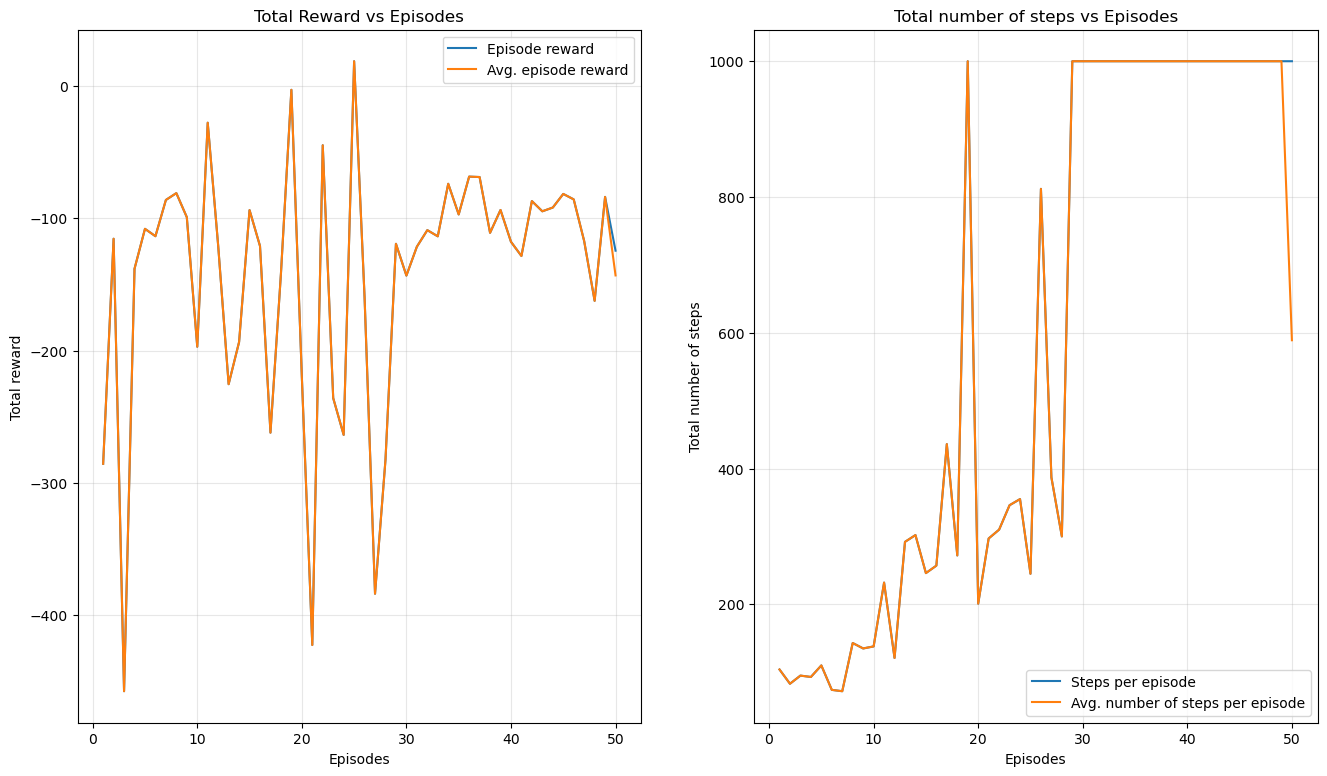

In [9]:
experiment_name = "DQN1"
plot_folder = "./plots/"
weights_folder = "./weights/"
os.makedirs(plot_folder, exist_ok=True)
os.makedirs(weights_folder, exist_ok=True)
nn_path = os.path.join(weights_folder, experiment_name + ".pth")
plot_path = os.path.join(plot_folder, experiment_name + ".png")

torch.save(network.to("cpu").state_dict(), nn_path)

plot(n_ep_running_average, episode_reward_list,
     episode_number_of_steps, plot_path)